# Testing Data Preprocessing Pipeline

In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
import os
from datetime import datetime
import re
import sys
sys.path.append('../src/')

import fasttext
import matplotlib as plt
import numpy as np
np.set_printoptions(precision=3)
import pandas as pd
import seaborn as sns
sns.set_theme()

In [3]:
BASE_DATA_PATH = "/data/ddmg/personalizedmentalhealth/reddit_project/data"
SR_DATA_PATH = "bitcoin/posts"

## Test Post Filtering Steps

In [4]:
data_df = pd.read_csv(os.path.join(BASE_DATA_PATH, SR_DATA_PATH, "all.csv"), index_col=0)

/data/ddmg/users/kmatton/.conda/envs/rlm/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (15,18,30,38,45,61,75,80,83,113,114,115,116,117,118,119,120) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
del_list = ['[removed]', '[deleted]']
data_df = data_df[~data_df["selftext"].isin(del_list)]
data_df = data_df[data_df["author"].notnull()]

In [6]:
id_counts = data_df['id'].value_counts()
assert len(set(id_counts)) == 1 and list(id_counts)[0] == 1

In [19]:
list(data_df.columns)

['_reddit',
 'approved_at_utc',
 'subreddit',
 'selftext',
 'author_fullname',
 'saved',
 'mod_reason_title',
 'gilded',
 'clicked',
 'title',
 'link_flair_richtext',
 'subreddit_name_prefixed',
 'hidden',
 'pwls',
 'link_flair_css_class',
 'downs',
 'thumbnail_height',
 'top_awarded_type',
 'hide_score',
 'name',
 'quarantine',
 'link_flair_text_color',
 'upvote_ratio',
 'author_flair_background_color',
 'subreddit_type',
 'ups',
 'total_awards_received',
 'media_embed',
 'thumbnail_width',
 'author_flair_template_id',
 'is_original_content',
 'user_reports',
 'secure_media',
 'is_reddit_media_domain',
 'is_meta',
 'category',
 'secure_media_embed',
 'link_flair_text',
 'can_mod_post',
 'score',
 'approved_by',
 'author_premium',
 'thumbnail',
 'edited',
 'author_flair_css_class',
 'author_flair_richtext',
 'gildings',
 'content_categories',
 'is_self',
 'mod_note',
 'created',
 'link_flair_type',
 'wls',
 'removed_by_category',
 'banned_by',
 'author_flair_type',
 'domain',
 'allow_l

# notes on columns:
* permalink is url address after reddit.com
* url is link to post, but if post is just a link then it is the url that the post links to (and url_overridden_by_dest will have this link)
* is_original_content column is always False --> not meaningful
* is_video is always False --> Not meaningful
* is_gallery and gallery data are always null --> not meaningful
* I don't think the selftext_html column is helpful for filtering or text pre-processing
* all posts have title, so shouldn't have to worry about that

In [51]:
list(data_df.head(5)['permalink'])

['/r/Bitcoin/comments/2s3rgw/sarutobi_has_now_done_more_than_25k_transactions/',
 '/r/Bitcoin/comments/2s3rb1/what_affects_the_bitcoin_price/',
 '/r/Bitcoin/comments/2s3qd8/where_did_the_blockchaininfo_firefox_addon_go/',
 '/r/Bitcoin/comments/2s3lt7/bitstamp_hacker_donated_1btc_to_sarutobi/',
 '/r/Bitcoin/comments/2s3j5i/if_i_dont_have_a_bank_account_what_are_my_options/']

In [25]:
list(data_df.iloc[6:11]['url'])

['https://www.reddit.com/r/Bitcoin/comments/2s3lt7/bitstamp_hacker_donated_1btc_to_sarutobi/',
 'http://sakurity.com/blog/2015/01/10/hacking-bitcoin-exchanger.html',
 'http://bitcoinvox.com/article/1380/bithalo-smart-contract-software-21',
 'http://www.btcfeed.net/uncategorized/layoffs/',
 'https://coinmarketcap.com/currencies/paycoin2/']

In [27]:
list(data_df.iloc[6:11]['url_overridden_by_dest'])

[nan,
 'http://sakurity.com/blog/2015/01/10/hacking-bitcoin-exchanger.html',
 'http://bitcoinvox.com/article/1380/bithalo-smart-contract-software-21',
 'http://www.btcfeed.net/uncategorized/layoffs/',
 'https://coinmarketcap.com/currencies/paycoin2/']

In [7]:
data_df = data_df[data_df["url_overridden_by_dest"].isnull()]

In [53]:
list(data_df.head(1)['selftext'])

['[First address] (https://blockchain.info/address/17ZgzoQUAiCrCgSieYfGhAvToW9kn6uaLt): 5255 transactions\n\n[Second address] (https://blockchain.info/address/1GumHq1f5XVnxBjnz78uRgJad2nyE5TgjS): 6671 transactions\n\n[Third (still active) address](https://blockchain.info/address/3MXxfNZoifLYdS8wJTpvfeDNPt9ZWuMAaN): 13164 transactions (and growing fast)\n\n']

In [54]:
list(data_df.head(1)['selftext_html'])

['<!-- SC_OFF --><div class="md"><p><a href="https://blockchain.info/address/17ZgzoQUAiCrCgSieYfGhAvToW9kn6uaLt">First address</a>: 5255 transactions</p>\n\n<p><a href="https://blockchain.info/address/1GumHq1f5XVnxBjnz78uRgJad2nyE5TgjS">Second address</a>: 6671 transactions</p>\n\n<p><a href="https://blockchain.info/address/3MXxfNZoifLYdS8wJTpvfeDNPt9ZWuMAaN">Third (still active) address</a>: 13164 transactions (and growing fast)</p>\n</div><!-- SC_ON -->']

In [8]:
keep_columns = ['id', 'author', 'title', 'selftext',
                'selftext_html', 'media', 'media_metadata']
data_df[keep_columns]

,id,author,title,selftext,selftext_html,media,media_metadata
0,2s3rgw,heltok,Sarutobi has now done more than 25k transactions,[First address] (https://blockchain.info/addre...,"<!-- SC_OFF --><div class=""md""><p><a href=""htt...",NaN,NaN
1,2s3rb1,Kimba_Coinarch,What affects the bitcoin price?,The recent Bitstamp hack has led people to que...,"<!-- SC_OFF --><div class=""md""><p>The recent B...",NaN,NaN
2,2s3qd8,Satirei,Where Did the Blockchain.info Firefox Add-On Go?,I found the github (which I think should be tr...,"<!-- SC_OFF --><div class=""md""><p>I found the ...",NaN,NaN
6,2s3lt7,heltok,Bitstamp hacker donated 1BTC to Sarutobi,I followed the transactions and found this cha...,"<!-- SC_OFF --><div class=""md""><p>I followed t...",NaN,NaN
14,2s3j5i,Alex_Engel,If I don't have a bank account what are my opt...,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
6629,knedzr,tookthisusersoucant,I created a Bitcoin node too!,&#x200B;\n\n[My Bitcoin + Lightning Node](http...,"<!-- SC_OFF --><div class=""md""><p>&#x200B;</p>...",NaN,"{'q9lggv62pe861': {'status': 'valid', 'e': 'Im..."
6631,knecae,sammyaxelrod,Bitcoin market cap now larger than Walmart and...,I know you’re sick of hearing it but I like co...,"<!-- SC_OFF --><div class=""md""><p>I know you’r...",NaN,NaN
6632,kneaub,Critical_Radio,Will the rise of Bitcoin speed up fiat inflation?,As less people want dollars and other fiat in ...,"<!-- SC_OFF --><div class=""md""><p>As less peop...",NaN,NaN
6633,kneap0,veletor,29k!!!!,AHHHHHHHHHHH 30 before New Years let’s go,"<!-- SC_OFF --><div class=""md""><p>AHHHHHHHHHHH...",NaN,NaN


## Examine Makeup of Data

In [30]:
copy_df = pd.read_csv(os.path.join(BASE_DATA_PATH, SR_DATA_PATH, "all.csv"), index_col=0)

/data/ddmg/users/kmatton/.conda/envs/rlm/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (15,18,30,38,45,61,75,80,83,113,114,115,116,117,118,119,120) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [31]:
print("total post count", len(copy_df))

total post count 663841


In [33]:
# get percentage of posts that have been removed/deleted
del_list = ['[removed]', '[deleted]']
del_df = copy_df[copy_df["selftext"].isin(del_list)]
print("number of posts that have been deleted/removed: {}={}%".format(len(del_df), len(del_df)*100/len(copy_df)))

number of posts that have been deleted/removed: 223204=33.62311155834002%


In [34]:
# get percentage of posts without an author --> note these are pretty much the same as posts that were deleted/removed
del_df = copy_df[copy_df["author"].isnull()]
print("number of posts w/o author: {}={}%".format(len(del_df), len(del_df)*100/len(copy_df)))

number of posts w/o author: 180354=27.168252638809594%


In [37]:
# get percentage of posts with url overridden by dest
del_df = copy_df[copy_df["url_overridden_by_dest"].notnull()]
print("number of posts w/ url overridden by dest: {}={}%".format(len(del_df), len(del_df)*100/len(copy_df)))

number of posts w/ url overridden by dest: 351209=52.90559034467591%


## Test Language Detection Models

Preprocessing steps needed before applying:
* Remove newlines

URLs lower confidence, but still is able to predict English correctly.

In [9]:
model_path = "/data/ddmg/personalizedmentalhealth/reddit_project/tools/lid.176.bin"
lang_id_model = fasttext.load_model(model_path)

In [68]:
def merge_text(row):
    text = row["title"]
    if isinstance(row["selftext"], str):
        text += " "
        text += row["selftext"]
    return text

In [69]:
data_df["text"] = data_df.apply(merge_text, axis=1)

In [76]:
texts = list(data_df["text"])

In [77]:
texts = [re.sub(r'\n+', ' ', text) for text in texts]

In [78]:
lang_preds = lang_id_model.predict(texts)

In [79]:
print(texts[0])
print(lang_preds[0][0])
print(lang_preds[1][0])

Sarutobi has now done more than 25k transactions [First address] (https://blockchain.info/address/17ZgzoQUAiCrCgSieYfGhAvToW9kn6uaLt): 5255 transactions [Second address] (https://blockchain.info/address/1GumHq1f5XVnxBjnz78uRgJad2nyE5TgjS): 6671 transactions [Third (still active) address](https://blockchain.info/address/3MXxfNZoifLYdS8wJTpvfeDNPt9ZWuMAaN): 13164 transactions (and growing fast) 
['__label__en']
[0.643]


In [83]:
non_eng_count = sum([x[0] != '__label__en' for x in lang_preds[0]])
print("non_eng: {}/{}={}%".format(non_eng_count, len(texts), non_eng_count*100/len(texts)))
non_eng_idxs = [i for i in range(len(texts)) if lang_preds[0][i][0] != '__label__en']
for idx in non_eng_idxs[10:20]:
    print("post at idx {}".format(idx))
    print(texts[idx])
    print()

non_eng: 203/150798=0.1346171699889919%
post at idx 11125
250 Celebrate.

post at idx 13282
Bitcoin moet het weer op eigen benen doen. Greek en China are not triggers anymore. So lets see if bitcoin can crawl back. Real time not: 275 

post at idx 15401
Reporte Semanal #2 Septiembre 2015 I Análisis de Mercado de Bitex.la La ultima semana pudimos observar como el precio del Bitcoin tuvo un claro y mantenido movimiento a la baja, tocando un piso en los 223 USD, el pasado Martes, en el día de la fecha el precio parece estar estabilizándose en el nivel de los 228 USD. Para la próxima semana podemos esperar que el precio vuelva a los niveles de la semana pasada si es que logra romper la barrera de los 230 USD. https://cdn-images-1.medium.com/max/1132/1*GuH7WGZ-TrvZUYmtMASB1w.png El director legal del Grupo de Société Générale ha pedido públicamente el establecimiento de un marco regulatorio para el bitcoin a nivel internacional. En un artículo co-escrito por Dominique Bourrinet, el director

Based on manual inspection, model appears to have high precision at detecting non-English posts (those that are said to be not-English aren't)

In [84]:
# check low confidence preds
conf_scores = [x[0] for x in lang_preds[1]]

<AxesSubplot:ylabel='Count'>

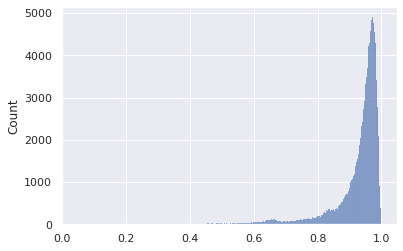

In [87]:
sns.histplot(conf_scores)

In [89]:
idxs_by_conf = np.argsort(conf_scores)
for i in range(10):
    post_idx = idxs_by_conf[i]
    print("post at idx {}".format(post_idx))
    print("lang: {}".format(lang_preds[0][post_idx][0]))
    print("conf: {}".format(lang_preds[1][post_idx][0]))
    print(texts[post_idx])
    print()

post at idx 2772
lang: __label__ml
conf: 0.045882698148489
150000 users

post at idx 137203
lang: __label__de
conf: 0.07228386402130127
Legit lol  https://preview.redd.it/ujvcdtagfi251.png?width=1850&format=png&auto=webp&s=1ee17529015fc9e31fecc692aa6e9f37f4c50d1c

post at idx 19664
lang: __label__uk
conf: 0.08601029217243195
420!

post at idx 56631
lang: __label__es
conf: 0.08881983906030655
Bitcoin music lit muthafuckas ¡Mayday! Murs  [banging on big banks table tops ](https://youtu.be/MUGBVz3RIHM) https://youtu.be/GmuJhxXD_zg

post at idx 131443
lang: __label__en
conf: 0.09308754652738571
Good video and content on bitcoin timestamping [https://youtu.be/b2NQWgwRb54](https://youtu.be/b2NQWgwRb54)

post at idx 54244
lang: __label__uk
conf: 0.09428723901510239
Go Bitcoin! Go Bitcoin!

post at idx 29765
lang: __label__en
conf: 0.09856415539979935
600 yes

post at idx 23413
lang: __label__en
conf: 0.10075394064188004
PSA: Machines that run bitcoin nodes will get wallet download attempts I'

Tends to have low confidence for short/weird posts. Could implement confidence threshold! (Although these posts are mainly English) --> but this helps to identify posts that aren't normal text.

In [92]:
for i in range(2000, 2100):
    post_idx = idxs_by_conf[i]
    print("post at idx {}".format(post_idx))
    print("lang: {}".format(lang_preds[0][post_idx][0]))
    print("conf: {}".format(lang_preds[1][post_idx][0]))
    print(texts[post_idx])
    print()

post at idx 112859
lang: __label__en
conf: 0.5496913194656372
lightning network withdraw errors Hi, I setup an raspiblitz lightning node, which is amazing and super easy to use. However, I have problems with withdrawing. Btw, for sending lightning payment, everything works perfectly. I tested [https://www.lightningspin.com](https://www.lightningspin.com/). When I tried to withdraw I am getting error. I also tested [https://lightning-roulette.com/](https://lightning-roulette.com/). Again I got an error: Here the error message from [https://lightning-roulette.com/](https://lightning-roulette.com/): unable to route payment to destination: TemporaryChannelFailure(update=(\*lnwire.ChannelUpdate)(0xc01fb4cbe0)({ Signature: (lnwire.Sig) (len=64 cap=64) { 00000000 38 9b 7d 09 c0 f5 c9 73 e3 4d e0 da c3 80 45 c1 |8.}....s.M....E.| 00000010 87 2c 17 2e 83 5c 49 7d e3 e7 23 29 b3 62 0f ac |.,...\\I}..#).b..| 00000020 38 e3 dd 22 14 08 7e 96 c1 1a 00 f8 6f 6d 4b 67 |8.."..\~.....omKg| 00000030 eb 

May also want to apply this *after* some basic preprocessing steps. e.g., remove links, apply word count min threshold.

## Removing Special Chars